In [77]:
# Load Libs
import geopandas
from pathlib import Path
import pandas as pd
import datetime
from matplotlib import pyplot as plt

from geopandas.tools import sjoin

In [78]:
# Load data

# Setup paths
INPUT_PATH = Path.cwd() / '..' / 'input'

# Paths to field boundaries
ce_boundary_path = INPUT_PATH / '20170206_CafRoughBoundaries' / 'CafCookEastArea.shp'
cw_boundary_path = INPUT_PATH / 'FromIanLeslie_CafGeospatial' / 'CE_CW_WGS1984' / 'CookWestBoundariesWGS1984' / 'CookWestBoundariesWGS1984.shp'

# Paths to georeference points
ce_gp_path = INPUT_PATH / 'CookEast_GeoReferencePoints_2016_IL' / 'All_CookEast.shp'
cw_gp_path = INPUT_PATH / 'FromIanLeslie_CafGeospatial' / 'CE_CW_WGS1984' / 'CookWestGeoRefPointsWGS1984' / 'CookWestGeoRefPoints_WGS1984.shp'

# Paths to treatment boundaries
treatment_paths = {
    'ce_treatment_path_1998To2015': INPUT_PATH / 'CookEastStrips' / 'Field_Plan_Final.shp',
    'ce_treatment_path_2016_C01': INPUT_PATH / 'CE_WGS1984_2016_OperationalFieldBoundaries' / 'C01' / 'C0117001.shp',
    'ce_treatment_path_2016_C02': INPUT_PATH / 'CE_WGS1984_2016_OperationalFieldBoundaries' / 'C02' / 'C0217001.shp',
    'ce_treatment_path_2017': INPUT_PATH / '20250307_CookEastFertZonesFromDataStream' / 'CE_SW_2zones2017rates' / 'CE_SW_2zones2017rates.shp',
    'ce_treatment_path_2018': '',  # No fert zones for 2018, crop was garbs
    'ce_treatment_path_2019': INPUT_PATH / '20250307_CookEastFertZonesFromDataStream' / 'CE_WW_2zones2019' / 'CE_WW_2zones2019.shp',
    'ce_treatment_path_2020': INPUT_PATH / '20250307_CookEastFertZonesFromDataStream' / 'CE_C01_Fert_2zones2020_WGS84' / 'CE_C01_Fert_2zones2020_WGS84.shp',
    'ce_treatment_path_2021': INPUT_PATH / '20250307_CookEastFertZonesFromDataStream' / 'WSU_C01_Fert_2zones2021_WGS84' / 'WSU_C01_Fert_2zones2021_WGS84.shp',
    'ce_treatment_path_2022': INPUT_PATH / '20250307_CookEastFertZonesFromDataStream' / 'WSU_C01_Fert_2zones2022_WGS84' / 'WSU_C01_Fert_2zones2022_WGS84' / 'WSU_C01_Fert_2zones2022_WGS84.shp'
}

<Axes: >

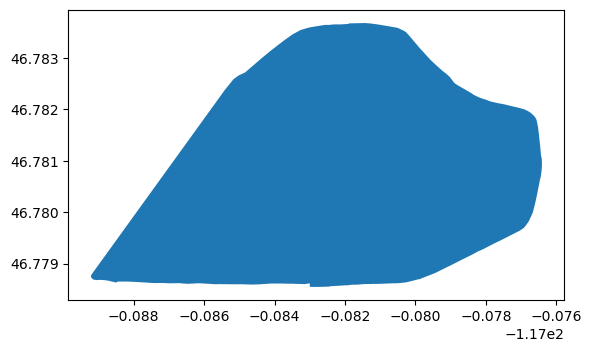

In [79]:
# Load boundary and convert to WGS84
ce_boundary_utm = geopandas.read_file(ce_boundary_path)
ce_boundary_utm.crs = '26911'
ce_boundary = ce_boundary_utm.to_crs('4326')
ce_boundary.plot()

In [80]:
ce = ce_boundary.assign(AreaId = 'CE',
                        StartDate = datetime.datetime(1998, 1, 1),
                        EndDate = None,
                        Description = 'Field boundary of Cook East')
ce = ce.drop(columns=['Id', 'Area', 'Perimeter', 'Acres', 'Hectares'])
ce.head()

,geometry,AreaId,StartDate,EndDate,Description
0,"POLYGON ((-117.08918 46.77881, -117.08541 46.7...",CE,1998-01-01,None,Field boundary of Cook East


<Axes: >

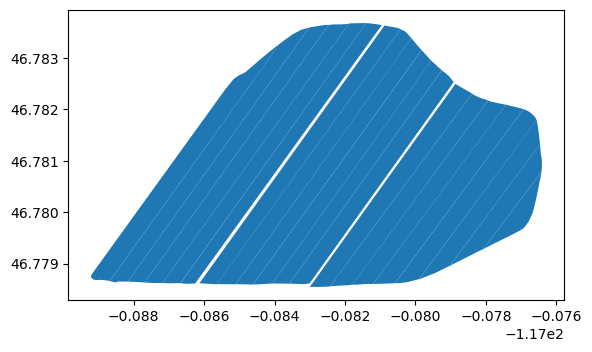

In [81]:
# Clean 1998-2015 polygons
# CE strips
cook_1998To2015_utm_11n = geopandas.read_file(treatment_paths['ce_treatment_path_1998To2015'])
cook_1998To2015_utm_11n.crs = '26911'

cook_1998To2015_utm_11n = (cook_1998To2015_utm_11n
    .to_crs('4326')
    .drop(
        ['Crop', 'Area', 'Perimeter', 'Area_ac', 'Ind_Field'],
        axis = 1))

ce_1998To2015 = cook_1998To2015_utm_11n[cook_1998To2015_utm_11n.intersects(ce_boundary.geometry.iloc[0])]
ce_1998To2015.plot()

In [82]:
ce_1998To2015.head()

,Strip,Field,geometry
5,6,A,"POLYGON ((-117.08667 46.77862, -117.08141 46.7..."
6,5,A,"POLYGON ((-117.08718 46.77863, -117.08189 46.7..."
7,4,A,"POLYGON ((-117.08769 46.77864, -117.08247 46.7..."
8,3,A,"POLYGON ((-117.08817 46.77865, -117.08302 46.7..."
9,2,A,"POLYGON ((-117.08868 46.77866, -117.08386 46.7..."


In [83]:
# Add standard fields
ce_1998To2015 = ce_1998To2015.assign(AreaId = ce_1998To2015['Field'].astype(str)+ce_1998To2015['Strip'].astype(str)).sort_values(by='AreaId')
ce_1998To2015['StartDate'] = datetime.datetime(1998, 1, 1)
ce_1998To2015['EndDate'] = datetime.datetime(2015, 12, 31)
ce_1998To2015['Description'] = ce_1998To2015.apply(lambda row: f"Field {row['Field']}, Strip {row['Strip']} of the crop diversification study", axis=1)
ce_1998To2015.head()

,Strip,Field,geometry,AreaId,StartDate,EndDate,Description
10,1,A,"POLYGON ((-117.08918 46.77881, -117.08541 46.7...",A1,1998-01-01,2015-12-31,"Field A, Strip 1 of the crop diversification s..."
9,2,A,"POLYGON ((-117.08868 46.77866, -117.08386 46.7...",A2,1998-01-01,2015-12-31,"Field A, Strip 2 of the crop diversification s..."
8,3,A,"POLYGON ((-117.08817 46.77865, -117.08302 46.7...",A3,1998-01-01,2015-12-31,"Field A, Strip 3 of the crop diversification s..."
7,4,A,"POLYGON ((-117.08769 46.77864, -117.08247 46.7...",A4,1998-01-01,2015-12-31,"Field A, Strip 4 of the crop diversification s..."
6,5,A,"POLYGON ((-117.08718 46.77863, -117.08189 46.7...",A5,1998-01-01,2015-12-31,"Field A, Strip 5 of the crop diversification s..."


In [84]:
# Clean up
ce_1998To2015 = ce_1998To2015.drop(columns=['Strip', 'Field'])
ce_1998To2015.head()

,geometry,AreaId,StartDate,EndDate,Description
10,"POLYGON ((-117.08918 46.77881, -117.08541 46.7...",A1,1998-01-01,2015-12-31,"Field A, Strip 1 of the crop diversification s..."
9,"POLYGON ((-117.08868 46.77866, -117.08386 46.7...",A2,1998-01-01,2015-12-31,"Field A, Strip 2 of the crop diversification s..."
8,"POLYGON ((-117.08817 46.77865, -117.08302 46.7...",A3,1998-01-01,2015-12-31,"Field A, Strip 3 of the crop diversification s..."
7,"POLYGON ((-117.08769 46.77864, -117.08247 46.7...",A4,1998-01-01,2015-12-31,"Field A, Strip 4 of the crop diversification s..."
6,"POLYGON ((-117.08718 46.77863, -117.08189 46.7...",A5,1998-01-01,2015-12-31,"Field A, Strip 5 of the crop diversification s..."


# Areas for 2016

<Axes: >

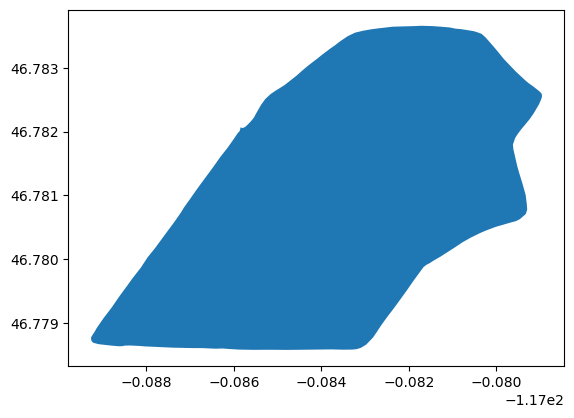

In [85]:
# Clean 2016 C01
ce_2016_C01 = geopandas.read_file(treatment_paths['ce_treatment_path_2016_C01'])
ce_2016_C01.crs = '4326'
ce_2016_C01.plot()


<Axes: >

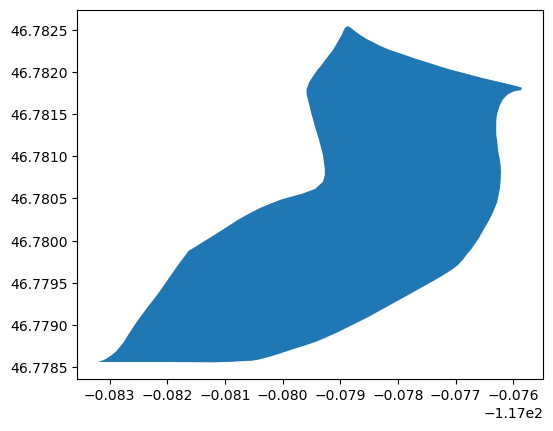

In [86]:
# Clean 2016 C02
ce_2016_C02 = geopandas.read_file(treatment_paths['ce_treatment_path_2016_C02'])
ce_2016_C02.crs = '4326'
ce_2016_C02.plot()


<Axes: >

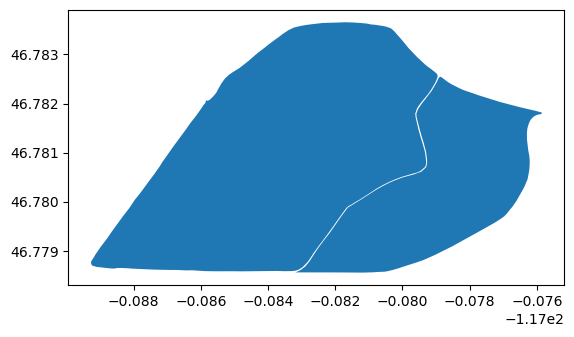

In [87]:
# Add standard fields and combine
ce_2016_C01 = ce_2016_C01.assign(AreaId = 'C01_2016', Description = 'Spring crop as part of a transition year before putting field into a uniform crop rotation')
ce_2016_C02 = ce_2016_C02.assign(AreaId = 'C02_2016', Description = 'Winter crop as part of a transition year before putting field into a uniform crop rotation')
ce_2016 = geopandas.GeoDataFrame(pd.concat([ce_2016_C01, ce_2016_C02], ignore_index=True), crs=ce_2016_C01.crs)
ce_2016 = ce_2016.assign(StartDate = datetime.datetime(2016, 1, 1), EndDate = datetime.datetime(2016, 12, 31)).sort_values(by='AreaId')

ce_2016.plot()

In [88]:
#ce_2016 = ce_2016.drop(columns=['Description'])
ce_2016.head()

,Description,geometry,AreaId,StartDate,EndDate
0,Spring crop as part of a transition year befor...,"POLYGON ((-117.08855 46.77864, -117.08864 46.7...",C01_2016,2016-01-01,2016-12-31
1,Winter crop as part of a transition year befor...,"POLYGON ((-117.08319 46.77856, -117.08312 46.7...",C02_2016,2016-01-01,2016-12-31


# Gridpoints

<Axes: >

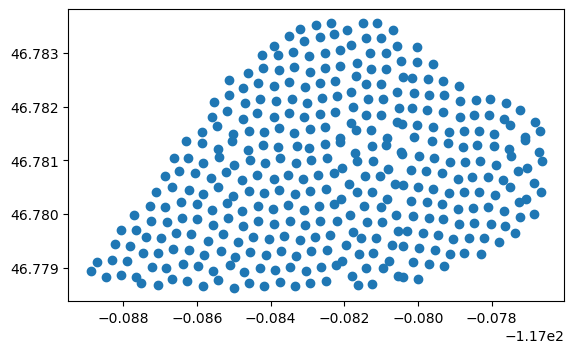

In [89]:
# CE Gridpoints
ce_gp_utm_11n = geopandas.read_file(ce_gp_path)
ce_gp_utm_11n.crs = '26911'

ce_gp = (ce_gp_utm_11n
    .to_crs('4326')
    .drop(
        ['FID_1', 'COLUMN', 'ROW', 'ROW2', 'COL_ROW', 'COL_ROW2', 
        'EASTING', 'NORTHING', 'CROP', 'AREA', 
        'PERIMETER', 'AREA_AC', 'TARGET', 'STRIP', 'FIELD'],
        axis = 1))

ce_gp.plot()

In [90]:
import numpy as np
import pandas as pd

ce_gp = ce_gp.assign(AreaId = ce_gp['ID2'].astype(str)).sort_values(by = ['ID2']).drop(columns=['ID2'])
# Enddate set for legacy data, actually extends to current (iso says leave end date as null)
ce_gp = ce_gp.assign(StartDate = datetime.datetime(1998, 1, 1), EndDate = None, Description = 'Georeference point (ID2) for reoccurring data collection in Cook East')
ce_gp.head()

,geometry,AreaId,StartDate,EndDate,Description
349,POINT (-117.08752 46.77873),1,1998-01-01,None,Georeference point (ID2) for reoccurring data ...
347,POINT (-117.08707 46.77869),2,1998-01-01,None,Georeference point (ID2) for reoccurring data ...
348,POINT (-117.08668 46.77879),3,1998-01-01,None,Georeference point (ID2) for reoccurring data ...
346,POINT (-117.08626 46.77876),4,1998-01-01,None,Georeference point (ID2) for reoccurring data ...
353,POINT (-117.08584 46.77866),5,1998-01-01,None,Georeference point (ID2) for reoccurring data ...


In [71]:
# CW Gridpoints
#cw_gp = geopandas.read_file(cw_gp_path)
#cw_gp.crs = '4326'
#cw_gp = cw_gp.drop(columns=['POINT_X', 'POINT_Y'])
#cw_gp.plot()

In [72]:
#cw_gp.head()

In [73]:
#cw_gp = cw_gp.rename(columns={'ID2': 'AreaId'})
#cw_gp = cw_gp.assign(StartDate = datetime.datetime(2017, 1, 1), EndDate = datetime.datetime(2016, 12, 31))


In [74]:
# TODO: Update grid points for HY2025 where we reduced the number of grid points. Need to add EndDate to those removed.

# Merge all and output as geojson

In [91]:
# 1998-2015 polygons, 2016 polygons, 1998-2016 gridpoints
# Combine all data
areaIds = geopandas.GeoDataFrame(pd.concat([ce, ce_1998To2015, ce_2016, ce_gp], ignore_index=True), crs=ce_1998To2015.crs)
areaIds.head(100)

C:\Users\bryan.carlson\AppData\Local\Temp\ipykernel_39472\1183526398.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  areaIds = geopandas.GeoDataFrame(pd.concat([ce, ce_1998To2015, ce_2016, ce_gp], ignore_index=True), crs=ce_1998To2015.crs)


,geometry,AreaId,StartDate,EndDate,Description
0,"POLYGON ((-117.08918 46.77881, -117.08541 46.7...",CE,1998-01-01,NaT,Field boundary of Cook East
1,"POLYGON ((-117.08918 46.77881, -117.08541 46.7...",A1,1998-01-01,2015-12-31,"Field A, Strip 1 of the crop diversification s..."
2,"POLYGON ((-117.08868 46.77866, -117.08386 46.7...",A2,1998-01-01,2015-12-31,"Field A, Strip 2 of the crop diversification s..."
3,"POLYGON ((-117.08817 46.77865, -117.08302 46.7...",A3,1998-01-01,2015-12-31,"Field A, Strip 3 of the crop diversification s..."
4,"POLYGON ((-117.08769 46.77864, -117.08247 46.7...",A4,1998-01-01,2015-12-31,"Field A, Strip 4 of the crop diversification s..."
...,...,...,...,...,...
95,POINT (-117.08617 46.77964),73,1998-01-01,NaT,Georeference point (ID2) for reoccurring data ...
96,POINT (-117.08569 46.77951),74,1998-01-01,NaT,Georeference point (ID2) for reoccurring data ...
97,POINT (-117.08531 46.77964),75,1998-01-01,NaT,Georeference point (ID2) for reoccurring data ...
98,POINT (-117.08489 46.77949),76,1998-01-01,NaT,Georeference point (ID2) for reoccurring data ...


In [92]:
# Output
#areaIds['AreaId'] = areaIds['AreaId'].astype(str)
now = datetime.datetime.now().strftime('%Y%m%d')
out_path = Path.cwd() / '..' / 'output'

areaIds.to_file(
    out_path / ('AreaIds_' + now + '.geojson'),
    driver='GeoJSON',
    index=False
)